<a href="https://colab.research.google.com/github/Daniel-923/Kor-Eng-Dictionary/blob/main/%EC%B5%9C%EC%A2%85%EB%B3%B8_topicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
import io
df = pd.read_csv('csvname_2.csv', encoding = 'cp949')

In [ ]:
df.head()

,title,summary
0,천마! 환생부터 만렙까지,가장 신뢰하던 친우의 배신으로 죽음에 이르게 된 천마 단신우.그는 믿을 수 없게도 ...
1,천마! 이계를 부수다,"""왜, 왜 죽였습니까?""""짜증이 나니까.""""겨우 그런 이유로 일국의 왕을 죽인단 말..."
2,천마님 안마하신다,현대로 돌아온 천마가 안마함
3,우주천마 3077,[제6회 대한민국 웹소설 공모대전 수상작]오랜 세월이 흘러 태산에 봉인된 천마가 눈...
4,진품명품 천마감정사!,"[해당 유물은 '진품'입니다.]유물, 화석, 디자인.내 눈에는 그 가치가 다 보인다."


In [ ]:
!pip install konlpy

In [ ]:
from konlpy.tag import Twitter
tagger = Twitter()

/usr/local/lib/python3.10/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [ ]:
def kor_noun(text):
    words = []
    for w in tagger.nouns(text):
        if len(w) > 1:
            words.append(w)
    return words

In [ ]:
kor_noun('한글은 한국어를 표현하는 문자인 것이다.')

['한글', '한국어', '표현', '문자']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=kor_noun, max_features=1000)

In [ ]:
summary = df['summary'].astype(str) + df['title'].astype(str)

In [ ]:
tdm = cv.fit_transform(summary)
words = cv.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
sorted(zip(tdm.sum(axis=0).flat, words), reverse=True)[:20]

[(422, '세상'),
 (401, '게임'),
 (328, '사랑'),
 (312, '그녀'),
 (304, '세계'),
 (295, '재벌'),
 (292, '회귀'),
 (277, '헌터'),
 (272, '천재'),
 (251, '시작'),
 (240, '무림'),
 (215, '결혼'),
 (212, '위해'),
 (206, '사람'),
 (203, '천마'),
 (203, '던전'),
 (197, '남자'),
 (190, '모든'),
 (189, '이혼'),
 (187, '남편')]

In [ ]:
!pip install gensim

In [ ]:
from gensim.matutils import Sparse2Corpus

corpus = Sparse2Corpus(tdm.T)

In [ ]:
from gensim.models.ldamodel import LdaModel
lda = LdaModel(corpus=corpus, id2word=dict(enumerate(words)),
               num_topics=8, passes=50, iterations=35,
               random_state=1234)

In [ ]:
topics = lda.print_topics(num_words= 4)
for topic in  topics:
  print(topic)

(0, '0.082*"게임" + 0.035*"세계" + 0.035*"세상" + 0.029*"몬스터"')
(1, '0.039*"공작" + 0.039*"남편" + 0.036*"빙의" + 0.033*"이혼"')
(2, '0.067*"망나니" + 0.027*"재벌" + 0.024*"축구" + 0.022*"귀환"')
(3, '0.033*"던전" + 0.032*"천재" + 0.030*"수상작" + 0.027*"지상"')
(4, '0.093*"차원" + 0.035*"세상" + 0.023*"헌터" + 0.023*"사람"')
(5, '0.054*"마법" + 0.032*"마법사" + 0.022*"헌터" + 0.020*"스킬"')
(6, '0.051*"무림" + 0.033*"천마" + 0.029*"재벌" + 0.020*"회귀"')
(7, '0.068*"그녀" + 0.047*"사랑" + 0.039*"남자" + 0.037*"결혼"')


In [ ]:
def tdm2doc(tdm, i):
    doc = []
    for i, n in enumerate(tdm[i].toarray().flat):
        if n > 0:
            doc.append((i, n))
    return doc

In [ ]:
doc = tdm2doc(tdm, 1)

In [ ]:
def getDoc():
  for i in range(500):
    doc = tdm2doc(tdm, i)
    title = df.loc[i, 'title']
    print(title , lda.get_document_topics(doc))

In [ ]:
def make_topictable_per_doc(lda, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(lda[corpus]):
        doc = topic_list[0] if lda.per_word_topics else topic_list
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)

        # 토픽 비중 초기화
        topic_distribution = [0.0] * lda.num_topics

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_name_num = int(topic_num)

                topic_name_num = [word for word, p in lda.show_topic(topic_name_num)]
                title = df.loc[i, 'title']

                # 토픽 비중의 길이를 맞추기
                topic_distribution = [(item[0], round(item[1], 2)) for item in topic_list]

                # 토픽 테이블에 추가
                topic_table = topic_table.append(pd.Series([title, int(topic_num), round(prop_topic, 2), topic_list, topic_name_num, topic_distribution]), ignore_index=True)
            else:
                break
    return topic_table


In [ ]:
# 토픽 테이블 생성
corpus = Sparse2Corpus(tdm.T)
topictable = make_topictable_per_doc(lda, corpus)
topictable = topictable.reset_index()
topictable.columns = ['문서 번호', '제목', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중', '토픽 이름', '토픽 비중']

topictable.head()

In [ ]:
pip install wordcloud matplotlib


In [ ]:
pip install --upgrade Pillow

In [ ]:
!pip install matplotlib numpy pandas


In [ ]:
#import matplotlib.font_manager as fm
#fontlist = fm.findSystemFonts(fontpaths=None, fontext='ttf')

In [ ]:
#import matplotlib
#import matplotlib.font_manager

#[f.fname for f in matplotlib.font_manager.fontManager.ttflist]

In [ ]:
#import matplotlib
#import matplotlib.font_manager

#[f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]

In [ ]:
#import matplotlib
#matplotlib.matplotlib_fname()



In [ ]:
# [(f.name, f.fname) for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]

여기부터 31~41라인은 위에 코드가 없어도 한글이 나오는지 모름

In [ ]:
!pip install konlpy

In [ ]:
!apt-get update -qq

In [ ]:
!apt-get install fonts-nanum* qq

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
E: Unable to locate package qq


In [ ]:
import matplotlib.font_manager as fm
sys_font = fm.findSystemFonts()

[f for f in sys_font if 'Nanum' in f]

['/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf']

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.font_manager

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

NanumGothic


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

def get_top_words_for_topic(topic_num, num_words=3):
    # 특정 토픽에서 가장 중요한 단어들을 가져오는 함수 (상위 num_words개)
    topics = lda.print_topics(num_words=num_words)
    top_words = [word.split('*')[1].strip().replace('"', '') for word in topics[topic_num][1].split('+')]
    return top_words

def get_topic_names(input_title):
    # 입력한 제목이 포함된 행을 찾기
    filtered_rows = topictable[topictable['제목'].str.contains(input_title)]

    if not filtered_rows.empty:
        # 제목이 포함된 행이 존재하는 경우
        row_title = filtered_rows.iloc[0]  # 여러 행이 아니라면 첫 번째 행을 선택
        topic_names = row_title['토픽 이름']
        print(f"제목 '{input_title}'의 토픽 이름: {topic_names}")

        # 비중이 없는 토픽에 대해 0으로 채워주기
        max_topics = lda.num_topics
        topic_distribution = row_title['각 토픽의 비중']
        filled_topic_distribution = [0.0] * max_topics
        for topic_num, prop_topic in topic_distribution:
            filled_topic_distribution[int(topic_num)] = round(prop_topic, 2)

        # 대표적인 토픽 하나와 해당 토픽의 비중 출력
        main_topic = np.argmax(filled_topic_distribution)
        main_topic_weight = round(filled_topic_distribution[main_topic], 2)
        print(f"대표적인 토픽: {main_topic}, 비중: {main_topic_weight}")

        # 각 토픽에 대한 대표적인 토픽 이름 3개와 비중 출력
        for i in range(max_topics):
            top_words = get_top_words_for_topic(i, num_words=3)  # 대표적인 토픽 이름 3개 가져오기
            topic_weight = round(filled_topic_distribution[i], 2)  # 해당 토픽의 비중 가져오기
            print(f"토픽 {i}: {top_words}, 비중: {topic_weight}")

        # 사용 예시: 토픽 분포 막대 그래프 그리기
        plot_topic_distribution(input_title, topic_names, filled_topic_distribution)

        # 워드 클라우드 생성 및 표시
        generate_word_cloud(input_title, topic_names)

    else:
        print(f"제목 '{input_title}'에 해당하는 데이터가 없습니다.")


하고 싶은 말을 입력해주세요 (0 입력 시 종료): 이세계 빚쟁이 공작
제목 '이세계 빚쟁이 공작'의 토픽 이름: ['마법', '마법사', '헌터', '스킬', '천재', '사람', '재능', '시대', '존재', '이번']
대표적인 토픽: 5, 비중: 0.3499999940395355
토픽 0: ['게임', '세계', '세상'], 비중: 0.14000000059604645
토픽 1: ['공작', '남편', '빙의'], 비중: 0.3100000023841858
토픽 2: ['망나니', '재벌', '축구'], 비중: 0.0
토픽 3: ['던전', '천재', '수상작'], 비중: 0.0
토픽 4: ['차원', '세상', '헌터'], 비중: 0.0
토픽 5: ['마법', '마법사', '헌터'], 비중: 0.3499999940395355
토픽 6: ['무림', '천마', '재벌'], 비중: 0.0
토픽 7: ['그녀', '사랑', '남자'], 비중: 0.17000000178813934


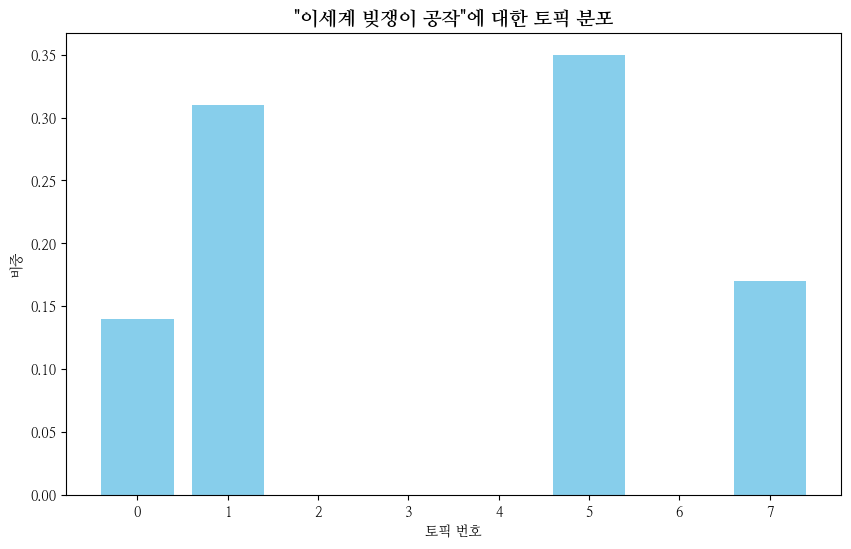

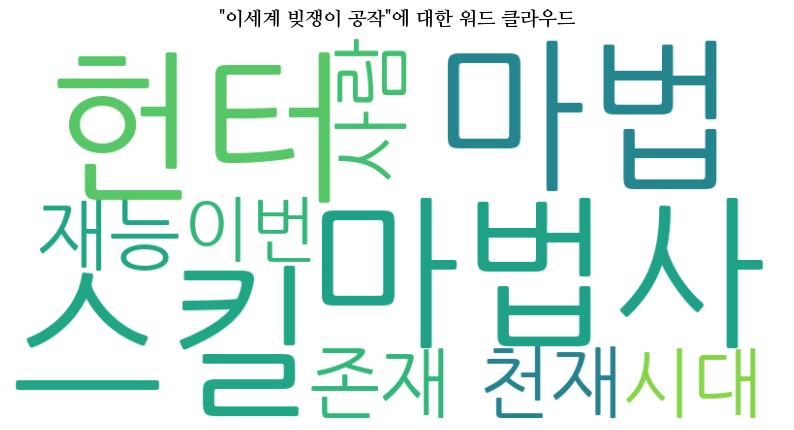

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np

# 나눔 폰트 설치
#!apt-get -y install fonts-nanum
#!fc-cache -fv
#!rm -rf ~/.cache/matplotlib

# 나눔 폰트 사용 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔 폰트 경로
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 설정
plt.rcParams['font.family'] = 'NanumMyeongjo'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

def generate_word_cloud(input_title, topic_names):
    # 워드 클라우드 생성
    text = ' '.join(topic_names)
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text)

    # matplotlib을 사용하여 워드 클라우드 표시
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'"{input_title}"에 대한 워드 클라우드', fontweight='bold', fontsize=14)
    plt.axis('off')
    plt.show()


def plot_topic_distribution(input_title, topic_names, topic_distribution):
    # topic_distribution을 평탄화하여 1차원 배열로 변환
    topic_distribution_flat = np.array(topic_distribution).flatten()

    # 토픽 번호
    topic_numbers = np.arange(len(topic_distribution_flat))

    # 막대 그래프 그리기
    plt.figure(figsize=(10, 6))
    plt.bar(topic_numbers, topic_distribution_flat, color='skyblue')
    plt.title(f'"{input_title}"에 대한 토픽 분포', fontweight='bold', fontsize=14)
    plt.xlabel('토픽 번호')
    plt.ylabel('비중')
    plt.xticks(topic_numbers, topic_numbers)  # 토픽 번호에 대응하는 토픽 이름으로 설정
    plt.show()

# 질문 무한 반복
while True:
    input_title = input("하고 싶은 말을 입력해주세요 (0 입력 시 종료): ")
    if input_title == '0':
        break

    get_topic_names(input_title)
    print("\n")


In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == '0' :
        break
    get_topic_names(sentence)
    print("\n")

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
## 학습 모델 저장
from gensim.test.utils import datapath, os

PATH = "/content/drive/MyDrive/colab_model/topic_modeling/lda_model1.gensim"



temp_file = datapath(PATH)
lda.save(temp_file)
